# Jupyter Notebook

In [7]:
import pandas as pd

train = pd.read_csv("train.csv")

if "id" in train.columns:
    train = train.drop(columns=["id"])

## Feature preparation & scaling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate target and features
X = train.drop(columns=["loan_paid_back"])
y = train["loan_paid_back"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

for col in categorical_cols:
    print(col, X[col].nunique())

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
X_train_processed.shape, X_val_processed.shape


gender 3
marital_status 4
education_level 5
employment_status 5
loan_purpose 8
grade_subgrade 30
Training set size: 475195
Validation set size: 118799


((475195, 60), (118799, 60))

## KNN Classifier

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# For KNN only: drop grade_subgrade column and sample 100,000 rows
X_train_knn = X_train.drop(columns=["grade_subgrade"]).copy()
X_val_knn = X_val.drop(columns=["grade_subgrade"]).copy()

knn_sample_size = 100000
knn_sample_indices = X_train_knn.sample(n=min(knn_sample_size, len(X_train_knn)), random_state=42).index
X_train_knn_sample = X_train_knn.loc[knn_sample_indices]
y_train_knn_sample = y_train.loc[knn_sample_indices]

# Create separate preprocessor for KNN (without grade_subgrade)
categorical_cols_knn = X_train_knn.select_dtypes(include=["object"]).columns.tolist()
numeric_cols_knn = X_train_knn.select_dtypes(include=["float64", "int64"]).columns.tolist()

preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_knn),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols_knn)
    ]
)

k_values = [75,125]

results_knn = {}

for k in k_values:
    print(f"Starting training with k={k}")
    knn = Pipeline(steps=[
        ("preprocess", preprocessor_knn),
        ("model", KNeighborsClassifier(n_neighbors=k))
    ])

    knn.fit(X_train_knn_sample, y_train_knn_sample)
    predictions_proba = knn.predict_proba(X_val_knn)[:, 1]
    predictions = knn.predict(X_val_knn)
    
    auc = roc_auc_score(y_val, predictions_proba)
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    
    results_knn[k] = {
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }
    print(f"KNN (k={k}) - AUC: {auc:.5f}, Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}")

results_knn

Starting training with k=75
KNN (k=75) - AUC: 0.89772, Accuracy: 0.89020, Precision: 0.88561, Recall: 0.99032
Starting training with k=125
KNN (k=125) - AUC: 0.89932, Accuracy: 0.88748, Precision: 0.88196, Recall: 0.99173


{75: {'AUC': 0.8977249609120559,
  'Accuracy': 0.8902010959688212,
  'Precision': 0.885614564663711,
  'Recall': 0.9903166599860762},
 125: {'AUC': 0.8993177457414732,
  'Accuracy': 0.8874822178637868,
  'Precision': 0.8819617076762882,
  'Recall': 0.9917301322756904}}

## Support Vector Machine (SVM)

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# Sample 25,000 rows for SVM training
svm_sample_size = 25000
svm_sample_indices = X_train.sample(n=min(svm_sample_size, len(X_train)), random_state=42).index
X_train_svm = X_train.loc[svm_sample_indices]
y_train_svm = y_train.loc[svm_sample_indices]

svm_models = [
    ("Linear SVM", SVC(kernel="linear", probability=True, C=1))
]

results_svm = {}

for name, model in svm_models:
    print(f"Starting with {name}")
    classifier = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    print(f"Starting fitting")
    classifier.fit(X_train_svm, y_train_svm)
    print(f"Starting predicting")
    preds_proba = classifier.predict_proba(X_val)[:, 1]
    preds = classifier.predict(X_val)
    print(f"Starting metric calculations")
    auc = roc_auc_score(y_val, preds_proba)
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    
    results_svm[name] = {
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }
    print(f"{name} - AUC: {auc:.5f}, Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}")

results_svm

Starting with Linear SVM
Starting fitting
Starting predicting
Starting metric calculations
Linear SVM - AUC: 0.86411, Accuracy: 0.89694, Precision: 0.89740, Recall: 0.98328


{'Linear SVM': {'AUC': 0.8641103757372919,
  'Accuracy': 0.896943576966136,
  'Precision': 0.897395908543923,
  'Recall': 0.9832809434400118}}

## Gradient Boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

gb_sample_size = 100000
gb_sample_indices = X_train.sample(n=min(gb_sample_size, len(X_train)), random_state=42).index
X_train_gb = X_train.loc[gb_sample_indices]
y_train_gb = y_train.loc[gb_sample_indices]


params = [
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 3},
    {"n_estimators": 300, "learning_rate": 0.1,  "max_depth": 3},
    {"n_estimators": 500, "learning_rate": 0.1,  "max_depth": 4},
]

results_gb = {}

for p in params:
    model = GradientBoostingClassifier(
        n_estimators=p["n_estimators"],
        learning_rate=p["learning_rate"],
        max_depth=p["max_depth"]
    )

    classifier = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    classifier.fit(X_train_gb, y_train_gb)
    preds_proba = classifier.predict_proba(X_val)[:, 1]
    preds = classifier.predict(X_val)
    
    auc = roc_auc_score(y_val, preds_proba)
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    
    name = f"GB: est={p['n_estimators']}, lr={p['learning_rate']}, depth={p['max_depth']}"
    results_gb[name] = {
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }
    print(f"{name} - AUC: {auc:.5f}, Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}")

results_gb

GB: est=200, lr=0.05, depth=3 - AUC: 0.91561, Accuracy: 0.90287, Precision: 0.90512, Recall: 0.98113
GB: est=300, lr=0.1, depth=3 - AUC: 0.91812, Accuracy: 0.90434, Precision: 0.90757, Recall: 0.97993
GB: est=500, lr=0.1, depth=4 - AUC: 0.91990, Accuracy: 0.90365, Precision: 0.90865, Recall: 0.97754


{'GB: est=200, lr=0.05, depth=3': {'AUC': 0.9156123456189251,
  'Accuracy': 0.9028695527740133,
  'Precision': 0.9051214931444197,
  'Recall': 0.9811290901035843},
 'GB: est=300, lr=0.1, depth=3': {'AUC': 0.9181217387428663,
  'Accuracy': 0.90434262914671,
  'Precision': 0.9075713169206722,
  'Recall': 0.9799265838273454},
 'GB: est=500, lr=0.1, depth=4': {'AUC': 0.9199005863299982,
  'Accuracy': 0.9036523876463607,
  'Precision': 0.9086479066575155,
  'Recall': 0.9775426678762051}}

# XGBoost

In [13]:
# Install xgboost in the current Python environment (if not already installed)
# This ensures it's installed in the same environment that Jupyter is using
# Using %pip ensures installation in the kernel's Python environment
%pip install xgboost --quiet
print("XGBoost installation check complete.")


Note: you may need to restart the kernel to use updated packages.
XGBoost installation check complete.


In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score


# Prepare data for XGBoost native categorical handling
# Convert categorical columns to pandas category dtype (XGBoost native format)
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()

# Get categorical columns (same as defined earlier)
categorical_cols_xgb = X_train_xgb.select_dtypes(include=["object"]).columns.tolist()

# Convert categorical columns to category dtype for XGBoost native handling
for col in categorical_cols_xgb:
    X_train_xgb[col] = X_train_xgb[col].astype("category")
    X_val_xgb[col] = X_val_xgb[col].astype("category")

# XGBoost parameters to try
xgb_params = [
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 3, "subsample": 0.8},
    {"n_estimators": 300, "learning_rate": 0.1, "max_depth": 4, "subsample": 0.8},
    {"n_estimators": 500, "learning_rate": 0.1, "max_depth": 5, "subsample": 0.9},
    {"n_estimators": 700, "learning_rate": 0.1, "max_depth": 6, "subsample": 0.9},
]

results_xgb = {}

for p in xgb_params:
    # enable_categorical=True tells XGBoost to use native categorical handling
    model = XGBClassifier(
        n_estimators=p["n_estimators"],
        learning_rate=p["learning_rate"],
        max_depth=p["max_depth"],
        subsample=p["subsample"],
        random_state=42,
        eval_metric="logloss",
        enable_categorical=True  # Enable native categorical feature handling
    )

    print(f"Training XGBoost: est={p['n_estimators']}, lr={p['learning_rate']}, depth={p['max_depth']}")
    model.fit(X_train_xgb, y_train)
    
    preds_proba = model.predict_proba(X_val_xgb)[:, 1]
    preds = model.predict(X_val_xgb)
    
    auc = roc_auc_score(y_val, preds_proba)
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    
    name = f"XGBoost: est={p['n_estimators']}, lr={p['learning_rate']}, depth={p['max_depth']}"
    results_xgb[name] = {
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }
    print(f"{name} - AUC: {auc:.5f}, Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}\n")

results_xgb


Training XGBoost: est=200, lr=0.05, depth=3
XGBoost: est=200, lr=0.05, depth=3 - AUC: 0.91631, Accuracy: 0.90268, Precision: 0.90366, Recall: 0.98284

Training XGBoost: est=300, lr=0.1, depth=4
XGBoost: est=300, lr=0.1, depth=4 - AUC: 0.92051, Accuracy: 0.90456, Precision: 0.90665, Recall: 0.98146

Training XGBoost: est=500, lr=0.1, depth=5
XGBoost: est=500, lr=0.1, depth=5 - AUC: 0.92152, Accuracy: 0.90456, Precision: 0.90833, Recall: 0.97923

Training XGBoost: est=700, lr=0.1, depth=6
XGBoost: est=700, lr=0.1, depth=6 - AUC: 0.92038, Accuracy: 0.90416, Precision: 0.90889, Recall: 0.97792



{'XGBoost: est=200, lr=0.05, depth=3': {'AUC': 0.9163131627679136,
  'Accuracy': 0.9026843660300171,
  'Precision': 0.9036553550126565,
  'Recall': 0.9828379148119238},
 'XGBoost: est=300, lr=0.1, depth=4': {'AUC': 0.9205069780118863,
  'Accuracy': 0.9045614862077964,
  'Precision': 0.9066495166822576,
  'Recall': 0.9814560874243159},
 'XGBoost: est=500, lr=0.1, depth=5': {'AUC': 0.9215175073698343,
  'Accuracy': 0.9045614862077964,
  'Precision': 0.9083286041369053,
  'Recall': 0.9792303959832072},
 'XGBoost: est=700, lr=0.1, depth=6': {'AUC': 0.9203806920349337,
  'Accuracy': 0.9041574424027138,
  'Precision': 0.9088939432560146,
  'Recall': 0.9779224067002806}}

## Logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_val_proba_lr = log_reg.predict_proba(X_val)[:, 1]
y_val_pred_lr = log_reg.predict(X_val)

auc_lr = roc_auc_score(y_val, y_val_proba_lr)
acc_lr = accuracy_score(y_val, y_val_pred_lr)
prec_lr = precision_score(y_val, y_val_pred_lr)
rec_lr = recall_score(y_val, y_val_pred_lr)

print(
    "LogisticRegression\n"
    f"AUC: {auc_lr:.5f}\n"
    f"Accuracy: {acc_lr:.5f}\n"
    f"Precision: {prec_lr:.5f}\n"
    f"Recall: {rec_lr:.5f}"
)


LogisticRegression
AUC: 0.91134
Accuracy: 0.90073
Precision: 0.90737
Recall: 0.97516


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

# AUC 
y_val_proba_rf = rf.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_val_proba_rf)

# accuracy/precision/recall
y_val_pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_val_pred_rf)
prec_rf = precision_score(y_val, y_val_pred_rf)
rec_rf = recall_score(y_val, y_val_pred_rf)

print(
    f"RandomForest\n"
    f"AUC: {auc_rf:.5f}\n"
    f"Accuracy: {acc_rf:.5f}\n"
    f"Precision: {prec_rf:.5f}\n"
    f"Recall: {rec_rf:.5f}"
)


RandomForest
AUC: 0.90765
Accuracy: 0.90165
Precision: 0.90416
Recall: 0.98071


## Models comparison

MODEL COMPARISON SUMMARY
              Model      AUC  Accuracy  Precision   Recall
            XGBoost 0.921518  0.904561   0.908329 0.979230
  Gradient Boosting 0.919901  0.903652   0.908648 0.977543
Logistic Regression 0.911336  0.900731   0.907366 0.975159
      Random Forest 0.907652  0.901649   0.904160 0.980707
        KNN (k=125) 0.899318  0.887482   0.881962 0.991730
                SVM 0.864110  0.896944   0.897396 0.983281




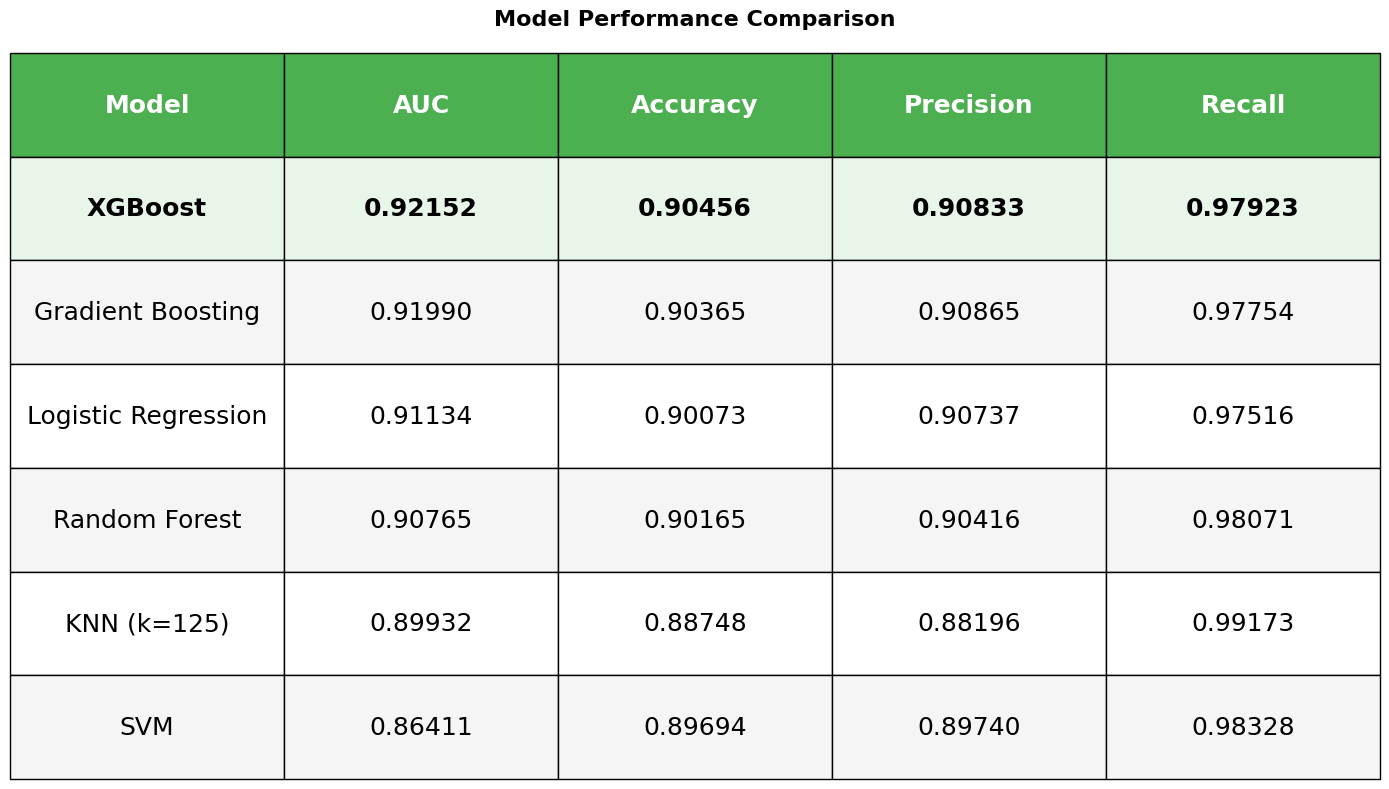

Best Models by Metric:
  Best AUC: XGBoost (0.92152)
  Best Accuracy: XGBoost (0.90456)
  Best Precision: Gradient Boosting (0.90865)
  Best Recall: KNN (k=125) (0.99173)


,Model,AUC,Accuracy,Precision,Recall
0,XGBoost,0.921518,0.904561,0.908329,0.979230
1,Gradient Boosting,0.919901,0.903652,0.908648,0.977543
2,Logistic Regression,0.911336,0.900731,0.907366,0.975159
3,Random Forest,0.907652,0.901649,0.904160,0.980707
4,KNN (k=125),0.899318,0.887482,0.881962,0.991730
5,SVM,0.864110,0.896944,0.897396,0.983281


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compile all results into a comparison dataframe
all_results = []

if 'results_knn' in globals():
    best_knn = max(results_knn.items(), key=lambda x: x[1]["AUC"])
    k, metrics = best_knn
    all_results.append({
        "Model": f"KNN (k={k})",
        "AUC": metrics["AUC"],
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"]
    })

if 'results_svm' in globals():
    best_svm = max(results_svm.items(), key=lambda x: x[1]["AUC"])
    name, metrics = best_svm
    all_results.append({
        "Model": "SVM",
        "AUC": metrics["AUC"],
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"]
    })

if 'results_gb' in globals():
    best_gb = max(results_gb.items(), key=lambda x: x[1]["AUC"])
    name, metrics = best_gb
    all_results.append({
        "Model": "Gradient Boosting",
        "AUC": metrics["AUC"],
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"]
    })

if 'results_xgb' in globals():
    best_xgb = max(results_xgb.items(), key=lambda x: x[1]["AUC"])
    name, metrics = best_xgb
    all_results.append({
        "Model": "XGBoost",
        "AUC": metrics["AUC"],
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"]
    })

if all(var in globals() for var in ['auc_lr', 'acc_lr', 'prec_lr', 'rec_lr']):
    all_results.append({
        "Model": "Logistic Regression",
        "AUC": auc_lr,
        "Accuracy": acc_lr,
        "Precision": prec_lr,
        "Recall": rec_lr
    })

if all(var in globals() for var in ['auc_rf', 'acc_rf', 'prec_rf', 'rec_rf']):
    all_results.append({
        "Model": "Random Forest",
        "AUC": auc_rf,
        "Accuracy": acc_rf,
        "Precision": prec_rf,
        "Recall": rec_rf
    })

# Create comparison dataframe
results_df = pd.DataFrame(all_results)

# Sort by AUC (descending)
results_df = results_df.sort_values("AUC", ascending=False).reset_index(drop=True)

# Display the dataframe
print("=" * 100)
print("MODEL COMPARISON SUMMARY")
print("=" * 100)
print(results_df.to_string(index=False))
print("\n")
    
fig, ax = plt.subplots(figsize=(14, max(8, len(results_df) * 0.6)))
ax.axis('tight')
ax.axis('off')

table_data = results_df.copy()
for col in ['AUC', 'Accuracy', 'Precision', 'Recall']:
    table_data[col] = table_data[col].apply(lambda x: f'{x:.5f}')

# Create table
table = ax.table(cellText=table_data.values,
                    colLabels=table_data.columns,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(1, 2)

# Color header row
for i in range(len(table_data.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best model row (first row since sorted by AUC)
for i in range(len(table_data.columns)):
    table[(1, i)].set_facecolor('#E8F5E9')
    table[(1, i)].set_text_props(weight='bold')

# Alternate row colors for better readability
for row in range(2, len(table_data) + 1):
    if row % 2 == 0:
        for col in range(len(table_data.columns)):
            table[(row, col)].set_facecolor('#F5F5F5')
    
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Also print best models by metric
print("Best Models by Metric:")
print(f"  Best AUC: {results_df.loc[results_df['AUC'].idxmax(), 'Model']} ({results_df['AUC'].max():.5f})")
print(f"  Best Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']} ({results_df['Accuracy'].max():.5f})")
print(f"  Best Precision: {results_df.loc[results_df['Precision'].idxmax(), 'Model']} ({results_df['Precision'].max():.5f})")
print(f"  Best Recall: {results_df.loc[results_df['Recall'].idxmax(), 'Model']} ({results_df['Recall'].max():.5f})")

# Display dataframe for easy copy
results_df